In [1]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
import logging
from razor.api import project_space_path
from math import ceil

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')


In [2]:
from razor.api import project_space_path
import razor
from razor import Technology, LibraryMode
import razor.flow as rf
import typing as t


In [3]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=3000))
class Configs:
    config: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
        
    def run(self):
        
        dic = {
          "TARGET": "sales",
          "END_TRAIN": 1913,
          "MAIN_INDEX": [
            "id",
            "d"
          ],
          'index_columns' : ['id','item_id','dept_id','cat_id','store_id','state_id'],
          "train_path": "M5Forecasting/sales_train_validation.csv",
          "prices_path": "M5Forecasting/sell_prices.csv",
          "calendar_path" : "M5Forecasting/calendar.csv"
        }
        self.config.put(dic)
        

In [4]:
configs = Configs()


In [5]:
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


In [6]:
TARGET = 'sales'         # Our main target
END_TRAIN = 1913         # Last day in train set
MAIN_INDEX = ['id','d']  # We can identify item by these columns


In [8]:
print('Load Main Data')

# Here are reafing all our data 
# without any limitations and dtype modification
train_df = pd.read_csv(project_space_path('M5Forecasting/sales_train_validation.csv'))
prices_df = pd.read_csv(project_space_path('M5Forecasting/sell_prices.csv'))
calendar_df = pd.read_csv(project_space_path('M5Forecasting/calendar.csv'))


Load Main Data


KeyboardInterrupt: 

In [34]:
train_df.to_csv(project_space_path('M5Forecasting/train_df.csv'), index=False)


In [7]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=10192))
class Melter:
    path: t.Any
    grid_df_path: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
        
    def run(self):
        
        train_df=pd.read_csv(project_space_path(self.path))
        print('Create Grid')

        # We can tranform horizontal representation 
        # to vertical "view"
        # Our "index" will be 'id','item_id','dept_id','cat_id','store_id','state_id'
        # and labels are 'd_' coulmns

        index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
        df = pd.melt(train_df, 
                          id_vars = index_columns, 
                          var_name = 'd', 
                          value_name = TARGET)
        
        df.to_csv(project_space_path('M5Forecasting/grid_df.csv'), index=False)
        self.grid_df_path.put('M5Forecasting/grid_df.csv')


In [8]:
melter = Melter(path='M5Forecasting/train_df.csv')


In [9]:
# p = rf.Pipeline("Melting", targets=[melter])  #preprocess


In [10]:
# deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)
# 

In [11]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=8192))
class HeavyOp1:
    path: t.Any
    config: t.Any
    add_grid_path: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
            
    def run(self):
        import pandas as pd
        import logging
        
        self.logger.info("Reading df")
        train_df=pd.read_csv(project_space_path(self.path))
        self.logger.info("Reading df DONE...")
        
        END_TRAIN = self.config["END_TRAIN"]
        TARGET = self.config["TARGET"]
        # If we look on train_df we se that 
        # we don't have a lot of traning rows
        # but each day can provide more train data
        print('Train rows:', len(train_df))

        # To be able to make predictions
        # we need to add "test set" to our grid
        index_columns = self.config['index_columns']
        df = pd.DataFrame()
        for i in range(1,29):
            temp_df = train_df[index_columns]
            temp_df = temp_df.drop_duplicates()
            temp_df['d'] = 'd_'+ str(END_TRAIN+i)
            temp_df[TARGET] = np.nan
            df = pd.concat([df,temp_df])
            
        self.logger.info(f'add grid  {df.shape}')
        df.to_csv(project_space_path('M5Forecasting/add_grid.csv'), index=False)
        self.add_grid_path.put('M5Forecasting/add_grid.csv')


In [12]:
heavy_op1 = HeavyOp1(path='M5Forecasting/train_df.csv', config=configs.config)


In [13]:
# p = rf.Pipeline("heavy_op1", targets=[heavy_op1], env=Technology.PYTHON)  #preprocess


In [14]:
# deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [15]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=13000))
class HeavyOp2:
    grid_df_path: t.Any
    add_grid_path: t.Any    
    config: t.Any    
    grid_df_int_path: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
        
    def run(self):
        
        def sizeof_fmt(num, suffix='B'):
            for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
                if abs(num) < 1024.0:
                    return "%3.1f%s%s" % (num, unit, suffix)
                num /= 1024.0
            return "%.1f%s%s" % (num, 'Yi', suffix)
        
        
        grid_df = pd.read_csv(project_space_path(self.grid_df_path))
        add_grid = pd.read_csv(project_space_path(self.add_grid_path))

        grid_df = pd.concat([grid_df,add_grid])
        grid_df = grid_df.reset_index(drop=True)


        # Let's check our memory usage
        self.logger.info("{:>20}: {:>8}".format('Original grid_df', sizeof_fmt(grid_df.memory_usage(index=True).sum())))

        # We can free some memory 
        # by converting "strings" to categorical
        # it will not affect merging and 
        # we will not lose any valuable data
        index_columns = self.config['index_columns']
        for col in index_columns:
            grid_df[col] = grid_df[col].astype('category')

        # Let's check again memory usage
        self.logger.info("{:>20}: {:>8}".format('Reduced grid_df', sizeof_fmt(grid_df.memory_usage(index=True).sum())))

        self.logger.info(f'grid int  {grid_df.head()}')
        grid_df.to_csv(project_space_path('M5Forecasting/grid_df_int.csv'))
        self.grid_df_int_path.put('M5Forecasting/grid_df_int.csv')


In [16]:
heavy_op2 = HeavyOp2(config=configs.config, add_grid_path=heavy_op1.add_grid_path, grid_df_path=melter.grid_df_path)
# heavy_op2 = HeavyOp2(config=configs.config, add_grid_path="M5Forecasting/add_grid.csv", grid_df_path="M5Forecasting/grid_df.csv")


In [17]:
# p = rf.Pipeline("heavy_op2", targets=[heavy_op2])  #preprocess


In [18]:
# deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [19]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=20000))
class HeavyOp3:
    grid_df_path: t.Any
    config: t.Any
    grid_pkl_path: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    
    
    def sizeof_fmt(self, num, suffix='B'):
        for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
            if abs(num) < 1024.0:
                return "%3.1f%s%s" % (num, unit, suffix)
            num /= 1024.0
        return "%.1f%s%s" % (num, 'Yi', suffix)


    def merge_by_concat(self, df1, df2, merge_on):
        merged_gf = df1[merge_on]
        merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
        new_columns = [col for col in list(merged_gf) if col not in merge_on]
        df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
        return df1
    
    def run(self):
        from razor.api import project_space_path
        
        prices_df = pd.read_csv(project_space_path(self.config['prices_path']))
        grid_df = pd.read_csv(project_space_path(self.grid_df_path))
        calendar_df = pd.read_csv(project_space_path(self.config['calendar_path']))
        # Prices are set by week
        # so it we will have not very accurate release week 
        release_df = prices_df.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index()
        release_df.columns = ['store_id','item_id','release']
        self.logger.info('Release Df')
        self.logger.info(release_df.head())
        
        self.logger.info('Release week')
        # Now we can merge release_df
        grid_df = self.merge_by_concat(grid_df, release_df, ['store_id','item_id'])
        del release_df


        grid_df = self.merge_by_concat(grid_df, calendar_df[['wm_yr_wk','d']], ['d'])
        self.logger.info(grid_df.columns)

        # Now we can cutoff some rows 
        # and safe memory 
        grid_df = grid_df[grid_df['wm_yr_wk']>=grid_df['release']]
        grid_df = grid_df.reset_index(drop=True)

        # Let's check our memory usage
        self.logger.info("{:>20}: {:>8}".format('Original grid_df',self.sizeof_fmt(grid_df.memory_usage(index=True).sum())))

        grid_df['release'] = grid_df['release'] - grid_df['release'].min()
        grid_df['release'] = grid_df['release'].astype(np.int16)

        # Let's check again memory usage
        self.logger.info("{:>20}: {:>8}".format('Reduced grid_df',self.sizeof_fmt(grid_df.memory_usage(index=True).sum())))

        grid_df = grid_df.drop(['Unnamed: 0'], 1)
#         grid_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_1.pkl'))
        grid_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_1.pkl'))
        self.logger.info(grid_df.shape)
        self.logger.info(grid_df.columns)
        
        grid_df.to_csv(project_space_path('M5Forecasting/grid_df_final.csv'))
        self.grid_pkl_path.put('M5Forecasting/m5-simple-fe/grid_part_1.pkl')
                       
                       

In [20]:
heavy_op3 = HeavyOp3(config=configs.config, grid_df_path=heavy_op2.grid_df_int_path)
# heavy_op3 = HeavyOp3(config=configs.config, grid_df_path='M5Forecasting/grid_df_int.csv')


In [21]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=20000))
class HeavyOp4:
    grid_path: t.Any
    config: t.Any
        
        
    def sizeof_fmt(self, num, suffix='B'):
            for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
                if abs(num) < 1024.0:
                    return "%3.1f%s%s" % (num, unit, suffix)
                num /= 1024.0
            return "%.1f%s%s" % (num, 'Yi', suffix)

        
    def merge_by_concat(self, df1, df2, merge_on):
        merged_gf = df1[merge_on]
        merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
        new_columns = [col for col in list(merged_gf) if col not in merge_on]
        df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
        return df1

    def reduce_mem_usage(self, df, verbose=True):
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        start_mem = df.memory_usage().sum() / 1024**2    
        for col in df.columns:
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                           df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
        end_mem = df.memory_usage().sum() / 1024**2

        if verbose: 
            print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

        return df
    
    def run(self):
        from razor.api import project_space_path

        prices_df=pd.read_csv(project_space_path(self.config["prices_path"]))
        calendar_df=pd.read_csv(project_space_path(self.config["calendar_path"]))
        
        self.logger.info('Release week')
        
        self.logger.info('Prices')

        # We can do some basic aggregations
        prices_df['price_max'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('max')
        prices_df['price_min'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('min')
        prices_df['price_std'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('std')
        prices_df['price_mean'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('mean')

        # and do price normalization (min/max scaling)
        prices_df['price_norm'] = prices_df['sell_price']/prices_df['price_max']

        # Some items are can be inflation dependent
        # and some items are very "stable"
        prices_df['price_nunique'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('nunique')
        prices_df['item_nunique'] = prices_df.groupby(['store_id','sell_price'])['item_id'].transform('nunique')

        # I would like some "rolling" aggregations
        # but would like months and years as "window"
        calendar_prices = calendar_df[['wm_yr_wk','month','year']]
        calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
        prices_df = prices_df.merge(calendar_prices[['wm_yr_wk','month','year']], on=['wm_yr_wk'], how='left')
        del calendar_prices

        # Now we can add price "momentum" (some sort of)
        # Shifted by week 
        # by month mean
        # by year mean
        prices_df['price_momentum'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id'])['sell_price'].transform(lambda x: x.shift(1))
        prices_df['price_momentum_m'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
        prices_df['price_momentum_y'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')

        del prices_df['month'], prices_df['year']
        
        ########################## Merge prices and save part 2
        #################################################################################
        self.logger.info('Merge prices and save part 2')

        grid_df = pd.read_pickle(project_space_path(self.grid_path))
        MAIN_INDEX=self.config["MAIN_INDEX"]
        
        # Merge Prices
        original_columns = list(grid_df)
        grid_df = grid_df.merge(prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')
        keep_columns = [col for col in list(grid_df) if col not in original_columns]
        grid_df = grid_df[MAIN_INDEX+keep_columns]
        grid_df = self.reduce_mem_usage(grid_df)

        # Safe part 2
        grid_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_2.pkl'))
        self.logger.info(f'Size: {grid_df.shape}')

        

In [22]:
heavy_op4 = HeavyOp4(config=configs.config, grid_path='M5Forecasting/m5-simple-fe/grid_part_1.pkl')
# heavy_op4 = HeavyOp4(config=configs.config, grid_path=heavy_op3.grid_pkl_path)


In [23]:
# p = rf.Pipeline("heavy_op4", targets=[heavy_op4])  #preprocess


In [24]:
# deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [25]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=20000))
class HeavyOp5:
    grid_path: t.Any
    config: t.Any
       
    
    def sizeof_fmt(self, num, suffix='B'):
        for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
            if abs(num) < 1024.0:
                return "%3.1f%s%s" % (num, unit, suffix)
            num /= 1024.0
        return "%.1f%s%s" % (num, 'Yi', suffix)


    def merge_by_concat(self, df1, df2, merge_on):
        merged_gf = df1[merge_on]
        merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
        new_columns = [col for col in list(merged_gf) if col not in merge_on]
        df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
        return df1
    
    def run(self):
        from razor.api import project_space_path
        
        calendar_df=pd.read_csv(project_space_path(self.config["calendar_path"]))
        grid_df = pd.read_pickle(project_space_path(self.grid_path))
        MAIN_INDEX=self.config["MAIN_INDEX"]
        
        ########################### Merge calendar
        #################################################################################
        grid_df = grid_df[MAIN_INDEX]

        # Merge calendar partly
        icols = ['date',
                 'd',
                 'event_name_1',
                 'event_type_1',
                 'event_name_2',
                 'event_type_2',
                 'snap_CA',
                 'snap_TX',
                 'snap_WI']
        
#         self.logger.info(f'dtypes  {grid_df.dtypes}')
        grid_df['d'] = grid_df['d'].apply(str)
#         self.logger.info(grid_df.dtypes)
#         self.logger.info(calendar_df.dtypes)

#         self.logger.info(f'Before NULL,  {calendar_df[icols].isnull().sum()}')
        grid_df = grid_df.merge(calendar_df[icols], on=['d'], how='left')
#         self.logger.info(f'After NULL,  {grid_df.isnull().sum()}')

        # Minify data
        # 'snap_' columns we can convert to bool or int8
        icols = ['event_name_1',
                 'event_type_1',
                 'event_name_2',
                 'event_type_2',
                 'snap_CA',
                 'snap_TX',
                 'snap_WI']
        for col in icols:
            grid_df[col] = grid_df[col].astype('category')

        # Convert to DateTime
        grid_df['date'] = pd.to_datetime(grid_df['date'])
        

        # Make some features from date
        grid_df['tm_d'] = grid_df['date'].dt.day.astype(np.int8)
        grid_df['tm_w'] = grid_df['date'].dt.week.astype(np.int8)
        grid_df['tm_m'] = grid_df['date'].dt.month.astype(np.int8)
        grid_df['tm_y'] = grid_df['date'].dt.year
        grid_df['tm_y'] = (grid_df['tm_y'] - grid_df['tm_y'].min()).astype(np.int8)
        grid_df['tm_wm'] = grid_df['tm_d'].apply(lambda x: ceil(x/7)).astype(np.int8)

        grid_df['tm_dw'] = grid_df['date'].dt.dayofweek.astype(np.int8)
        grid_df['tm_w_end'] = (grid_df['tm_dw']>=5).astype(np.int8)

        # Remove date
        del grid_df['date']
        ########################### Save part 3 (Dates)
        #################################################################################
        print('Save part 3')

        # Safe part 3
        grid_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_3.pkl'))
        print('Size:', grid_df.shape)

        # We don't need calendar_df anymore
        del calendar_df
        del grid_df



In [26]:
heavy_op5 = HeavyOp5(config=configs.config, grid_path=heavy_op3.grid_pkl_path)
# heavy_op5 = HeavyOp5(config=configs.config, grid_path='M5Forecasting/debug/grid_part_1.pkl')


In [27]:
p = rf.Pipeline("heavy_op5", targets=[heavy_op4, heavy_op5])  #preprocess
# p = rf.Pipeline("heavy_op5", targets=[heavy_op5])  #preprocess


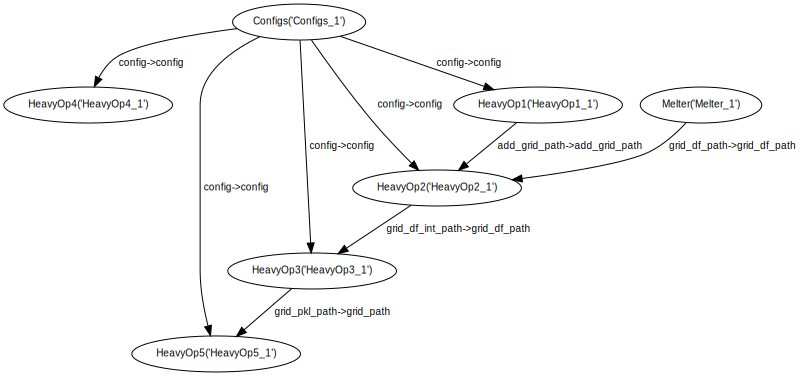

In [28]:
p

In [29]:
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [30]:
deployed_pipeline

PlatformPipelineRun(project_id='c0b26d85-a4c9-44f5-9d0e-f540dd2de644', pipeline_id='ea0b7b00-061e-11eb-a699-0242ac110004', pipeline_name='heavy_op5', pipeline_run_id='66cc3aca-1a9c-4a3e-bcaa-17d433e5a13a', pipeline_version=None, comment=None, created_on='2020-10-04T08:52:23.899+00:00', start_time=None, end_time=None, eta=0, run_at=1601801543899, run_duration=0, compute_time=0, wait_time=438, ran_by_user=RanByUser(user_name='Ayan Basak', email='ayan.basak@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='66cc3aca-1a9c-4a3e-bcaa-17d433e5a13a', pipeline_name='heavy_op5', pipeline_status='IN_PROGRESS', block_id='c3419326-2ca8-47a0-9510-02820270eb0e', block_run_id='671da520-fc32-431d-b86a-9465cadd686e', block_name='Configs_1', resource_spec=ResourceAllocated(cores=2, memory=3000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='c3419326-2ca8-47a0-9510-02820270eb0e', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-10-04T08:52:25.000+00:00'), PlatformPipelineBlockRun(pipeline_run_id='66cc3aca-1a9c-4a3e-bcaa-17d433e5a13a', pipeline_name='heavy_op5', pipeline_status='IN_PROGRESS', block_id='eb9ec22d-7b15-485a-9783-2c2c877d448d', block_run_id='c2f0fd4e-555a-4634-b640-52928ed416a6', block_name='Melter_1', resource_spec=ResourceAllocated(cores=2, memory=10192, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='eb9ec22d-7b15-485a-9783-2c2c877d448d', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-10-04T08:52:25.000+00:00'), PlatformPipelineBlockRun(pipeline_run_id='66cc3aca-1a9c-4a3e-bcaa-17d433e5a13a', pipeline_name='heavy_op5', pipeline_status='IN_PROGRESS', block_id='8fdb4b7c-a5ec-4c6d-9208-67afde20d8c3', block_run_id='9177bac4-d5ee-4c97-98aa-4333a742d9d8', block_name='HeavyOp4_1', resource_spec=ResourceAllocated(cores=2, memory=20000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='YET_TO_START', containers=[], cluster_id='8fdb4b7c-a5ec-4c6d-9208-67afde20d8c3', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at=None), PlatformPipelineBlockRun(pipeline_run_id='66cc3aca-1a9c-4a3e-bcaa-17d433e5a13a', pipeline_name='heavy_op5', pipeline_status='IN_PROGRESS', block_id='c5797e32-4f1a-4971-a64c-5e6c6b84c83d', block_run_id='96c750ed-6f71-43d6-8397-308f9d73858a', block_name='HeavyOp1_1', resource_spec=ResourceAllocated(cores=2, memory=8192, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='YET_TO_START', containers=[], cluster_id='c5797e32-4f1a-4971-a64c-5e6c6b84c83d', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at=None), PlatformPipelineBlockRun(pipeline_run_id='66cc3aca-1a9c-4a3e-bcaa-17d433e5a13a', pipeline_name='heavy_op5', pipeline_status='IN_PROGRESS', block_id='28ef8589-7914-4738-9bfa-0b94572cfd9c', block_run_id='0b9bc59e-2c64-4024-9eab-bc331f8c60e7', block_name='HeavyOp2_1', resource_spec=ResourceAllocated(cores=2, memory=13000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCor